Attempt to finetune DistilBERT-base-uncased for Arxiv papers multiclassification:
- Prepare dataset
- Tokenize
- Load model
- Define metrics
- Define Trainer object and TrainingArguments
- Evaluate predictions
- Error analysis


In [3]:
import pandas as pd
import numpy as np
from datasets import load_from_disk

all_stream_data = load_from_disk("data/processed/all_stream_data")


In [4]:
all_stream_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 71157
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1671
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1672
    })
})

In [5]:
from transformers import AutoTokenizer
import torch

model_id = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


In [6]:
train_dataset = all_stream_data["train"].map(tokenize, batched=True, batch_size=None)

eval_dataset = all_stream_data["validation"].map(tokenize, batched=True, batch_size=None)


In [7]:
labels = all_stream_data["train"].features["label"].names
y_valid = np.array(eval_dataset["label"])


In [8]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
model = (AutoModelForSequenceClassification
        .from_pretrained(model_id, num_labels=num_labels)
        .to(device))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()


In [15]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import balanced_accuracy_score, f1_score

batch_size = 64
num_train_epochs = 4
learning_rate = 2e-5
logging_steps = len(train_dataset) // batch_size
model_name = f"./models/{model_id}-focal-finetuned-arxiv"
training_args = TrainingArguments(output_dir=model_name,
                                  overwrite_output_dir=True,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=learning_rate,
                                  lr_scheduler_type="linear",
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size * 2,
                                  weight_decay=0.01,
                                  warmup_steps=500,
                                  fp16=True,
                                  eval_strategy="steps",
                                  eval_steps=500,
                                  save_strategy="steps",
                                  save_total_limit=3,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="macro_f1",
                                  greater_is_better=True,
                                  push_to_hub=True,
                                  label_smoothing_factor=0.1,
                                  log_level="error")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    macro_f1 = f1_score(labels, preds, average="macro")
    balanced_accuracy = balanced_accuracy_score(labels, preds)
    return {"macro_f1": macro_f1, "balanced_accuracy": balanced_accuracy}


In [13]:
# from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F

# Calculate class weights
# train_labels = np.array(train_dataset["label"])
# class_weights = compute_class_weight(
#     class_weight="balanced",
#     classes=np.unique(train_labels),
#     y=train_labels
# )

# Convert to PyTorch tensor and move to the right device
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

class CustomTrainer(Trainer):
    def __init__(self, *args, loss_fn=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn
        
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        loss = self.loss_fn(logits, labels)

        # if self.use_focal_loss:
        #     loss = self.focal_loss(logits, labels)
        # else:
        # # Apply class weights to the loss
        #     loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device) if self.class_weights is not None else None)
        #     loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

# def focal_loss(self, logits, labels):
#     if self.class_weights is not None:
#         ce_loss = F.cross_entropy(logits, labels, reduction="none", weight=self.class_weights.to(logits.device))
#     else:
#         ce_loss = F.cross_entropy(logits, labels, reduction="none")        
#     pt = torch.exp(-ce_loss)
#     focal_term = (1 - pt) ** self.gamma
#     return (focal_term * ce_loss).mean()
    
def focal_loss(logits, labels, gamma=2.0, alpha=0.25):
    # Calculate standard cross-entropy loss first.
    ce_loss = F.cross_entropy(logits, labels, reduction='none')
    
    # Get softmax probabilities.
    pt = torch.exp(-ce_loss)
    
    # Compute focal loss.
    focal_loss = alpha * (1 - pt) ** gamma * ce_loss
    return focal_loss.mean()


In [16]:
# trainer = CustomTrainer(
#     class_weights=class_weights,
#     use_focal_loss=True,
#     gamma=2.0,
#     model=model, 
#     args=training_args,
#     compute_metrics=compute_metrics,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     processing_class=tokenizer,
#     loss_fn=focal_loss,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
# )


trainer = CustomTrainer(
    model=model, 
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
    loss_fn=focal_loss,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
)

trainer.train()


Step,Training Loss,Validation Loss,Macro F1,Balanced Accuracy
500,No log,0.061295,0.688349,0.673069
1000,No log,0.064598,0.649476,0.643618
1500,0.032500,0.064965,0.667952,0.681790
2000,0.032500,0.067800,0.668827,0.674810
2500,0.024500,0.070957,0.672353,0.670778
3000,0.024500,0.069866,0.645790,0.636290
3500,0.016100,0.069800,0.673866,0.667789
4000,0.016100,0.071630,0.677123,0.671451


TrainOutput(global_step=4448, training_loss=0.021139120338853155, metrics={'train_runtime': 1226.2428, 'train_samples_per_second': 232.114, 'train_steps_per_second': 3.627, 'total_flos': 3.771334428976742e+16, 'train_loss': 0.021139120338853155, 'epoch': 4.0})

In [19]:
preds_output = trainer.predict(eval_dataset)


In [20]:
preds_output.metrics


{'test_loss': 0.9278122782707214,
 'test_macro_f1': 0.673340316288656,
 'test_balanced_accuracy': 0.6794465592626018,
 'test_runtime': 2.8818,
 'test_samples_per_second': 579.849,
 'test_steps_per_second': 9.369}

In [21]:
y_preds = np.argmax(preds_output.predictions, axis=1)


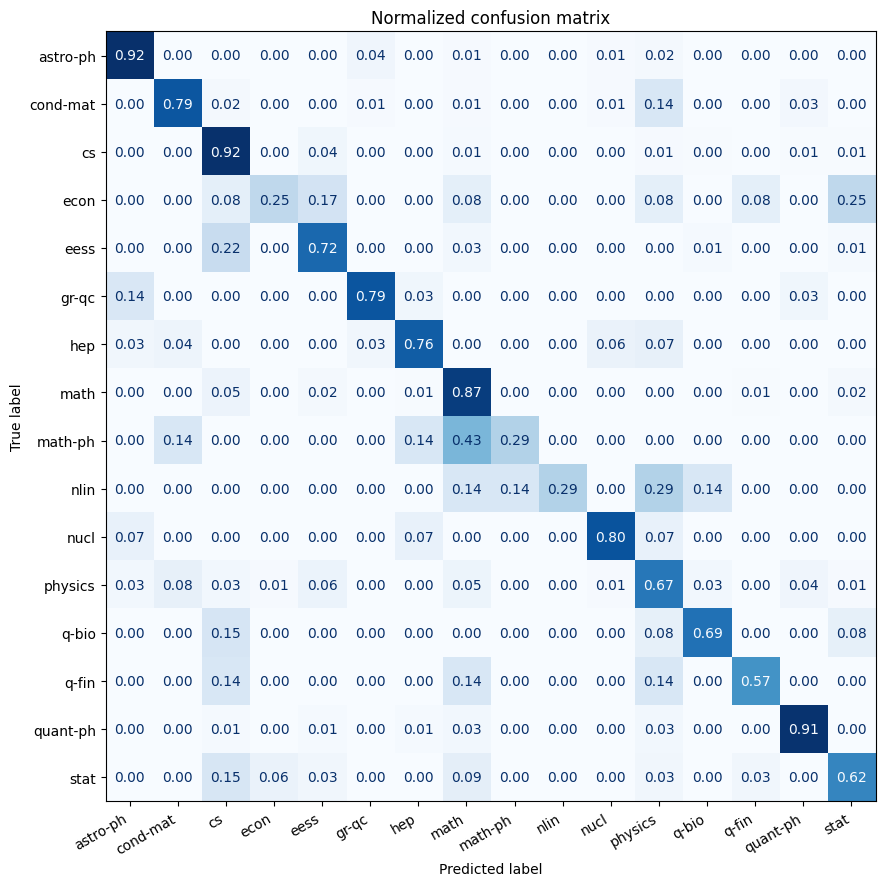

In [22]:
from src.utils import plot_confusion_matrix

plot_confusion_matrix(y_preds, y_valid, labels)


In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                         reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}


In [ ]:
# Convert our dataset back to PyTorch tensors
data_encoded.set_format("torch",
                        columns=["input_ids", "attention_mask", "label"])
# Compute loss values
data_encoded["validation"] = data_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)


In [ ]:
def label_int2str(row):
    return data["train"].features["label"].int2str(row)


In [ ]:
data_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = data_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))


In [ ]:
df_test.sort_values("loss", ascending=False).head(10)


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)
